![Logo](assets/logo.png)

Made by **Domonkos Nagy**

# Gridworld Generator

This notebook demonstrates the use of the `Gridworld` class I made to easily generate and visualize gridworld environments.

In [1]:
import numpy as np
from gridworld import Gridworld
import gymnasium as gym
import matplotlib.pyplot as plt
import time
from IPython import display
import pickle

## Initialization

To initialize a gridworld, first you have to define the grid itself. You can do this by creating two identically shaped `ndarray`-s, each element of the arrays representing a cell:

- `state_types` represents how each cell of the gridworld behaves. Elements have 3 possible values:
    - 0: standard cell, with possible actions UP, RIGHT, DOWN, LEFT,
    - 1: goal cell, visiting this cell terminates the episode,
    - 2: wall, this is a cell that can't be stepped on.
- `rewards` represents the reward given for visiting the cell.

This is enough for a standard initialization. Additionally, a number of optional parameters can be passed:
- `q_table` is the Q-table representing the current state-action values. It has to be 3-dimensional, with the shape matching the gridworld and the number of actions (4):
for example, if the shape of the gridworld is (2, 5), the shape of the Q-table must be (2, 5, 4). If not passed, a default Q-table is initialized with 0s in all positions.
- `slip` is a dictionary containing slipping probabilities after taking an action. It must have 3 keys, 'left', 'right' and 'backward', each representing the probability
of slipping in these directions when the supposed action is 'forward'. The supposed action is taken with probability $1 - \text{(sum of slipping probabilities)}$.
By default, all values are 0, meaning that there is no stochasticity.
- `gamma` is the discount factor ($\gamma$) for the environment. By default, it is 1.
- `step_reward` is the standard reward (penalty) for each step, where the reward would otherwise be 0. The default value is -0.01.

This example shows the initialization of a simple gridworld environment:

In [2]:
# Gridworld shape
shape = (3, 4)

# State types
state_types = np.zeros(shape, dtype=int)
state_types[0, 3] = 1
state_types[1, 3] = 1
state_types[1, 1] = 2

# Rewards
rewards = np.zeros(shape, dtype=int)
rewards[0, 3] = 1
rewards[1, 3] = -1

# Q-table
q_table = np.zeros(shape + (4,))

# Slip probabilities
slip = {
    'left': 0.2,
    'right': 0.2,
    'backward': 0
}

# Initializing gridworld
gw = Gridworld(state_types, rewards, q_table,
               slip=slip, gamma=0.9, step_reward=0)

print('State types:')
print(state_types)
print('Rewards:')
print(rewards)

State types:
[[0 0 0 1]
 [0 2 0 1]
 [0 0 0 0]]
Rewards:
[[ 0  0  0  1]
 [ 0  0  0 -1]
 [ 0  0  0  0]]


## Rendering

The `render` function returns an image of the gridworld with the current Q-values for each state:
- for normal states, the Q-value for each direction is displayed,
- for goal states, the reward is displayed (since the Q-values of actions in goal states are always 0),
- for walls, an empty grey rectangle is displayed.

By passing the `policy=True` option, the current policy along with the Q-values of the best action is displayed.

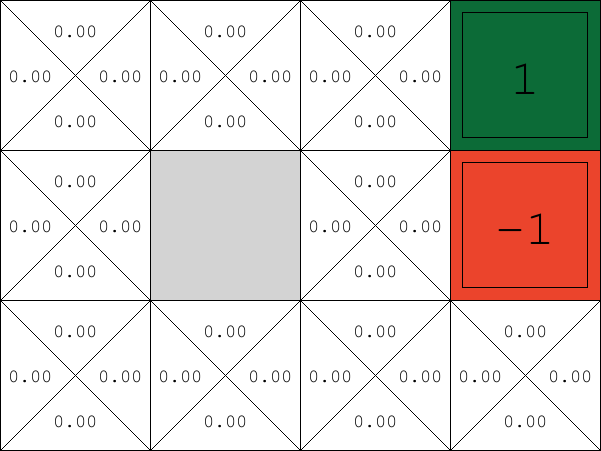

In [3]:
# Rendering Q-values
display.display(gw.render())

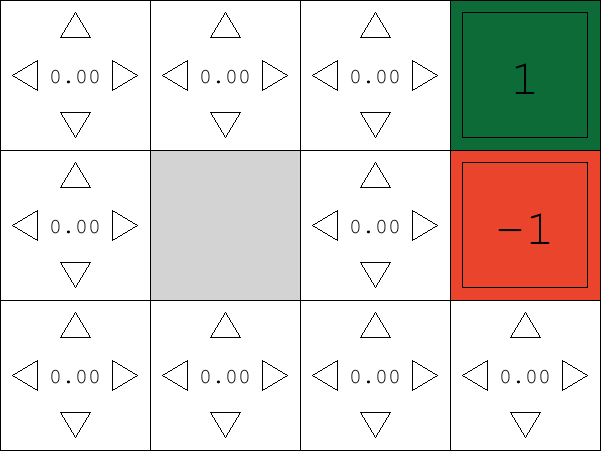

In [4]:
# Rendering policy
display.display(gw.render(policy=True))

## Solving

The `solve` methods find the optimal policy and Q-values using value iteration.

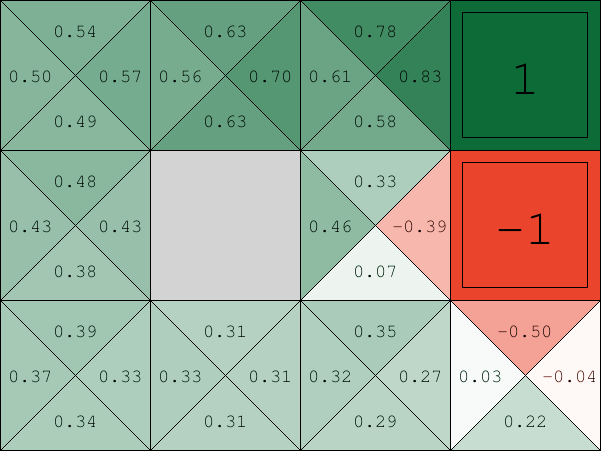

In [5]:
# Solving gridworld
gw.solve()

# Rendering Q-values
display.display(gw.render())

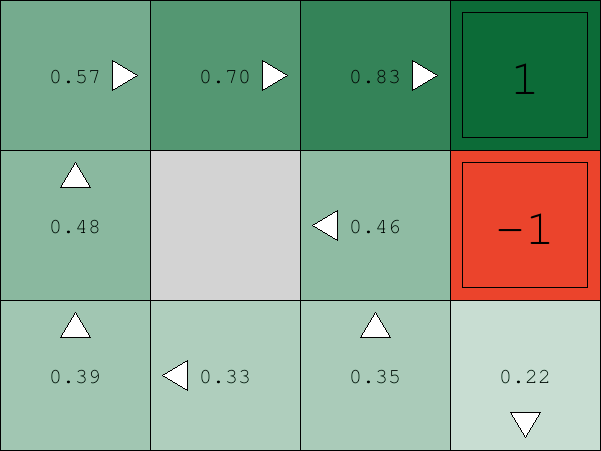

In [6]:
# Rendering policy
display.display(gw.render(policy=True))

## Overlaying

Since the `render` method returns an image, it can be used to overlay the Q-table/policy on a Gymnasium environment,
and see how it updates with experience in real time. This example shows a half-learned Q-table overlaid on the Frozen Lake environment:

In [7]:
# Hyperparameters
N_EPISODES = 5
MAX_STEPS_PER_EPISODE = 100

ALPHA = 0.1  # learning rate
GAMMA = 0.98  # discount rate
EPSILON = 0.1  # exploration rate

In [8]:
# State types
state_types = np.zeros((4, 4), dtype=int)
state_types[3, 3] = 1
state_types[3, 0] = 1
state_types[1, 1] = 1
state_types[1, 3] = 1
state_types[2, 3] = 1

# Rewards
rewards = np.zeros((4, 4), dtype=int)
rewards[3, 3] = 1

# Half-learned Q-table
with open('q_table.bin', 'rb') as f:
    q_table = pickle.load(f)

# Slip probabilities
slip = {
    'left': 1/3,
    'right': 1/3,
    'backward': 0
}

# Initializing gridworld
gw = Gridworld(state_types, rewards, q_table,
               slip=slip, gamma=GAMMA, step_reward=0)

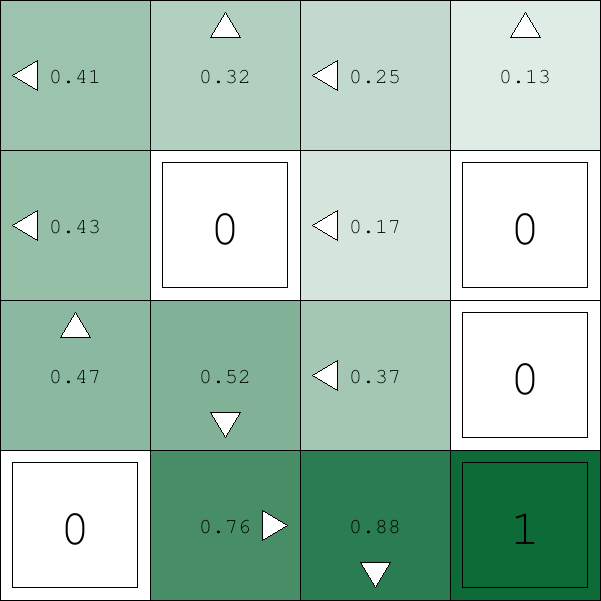

In [9]:
display.display(gw.render(policy=True))

In [10]:
# Functions to translate between the two gridworld representations
def action_translate(action):
    dict = {
        0: 3,
        1: 2,
        2: 1,
        3: 0
    }
    return dict[action]

def state_translate(state):
    j = state % 4
    i = state // 4
    return i, j

# Argmax function that breaks ties randomly
def argmax(arr):
    arr_max = np.max(arr)
    return np.random.choice(np.where(arr == arr_max)[0])

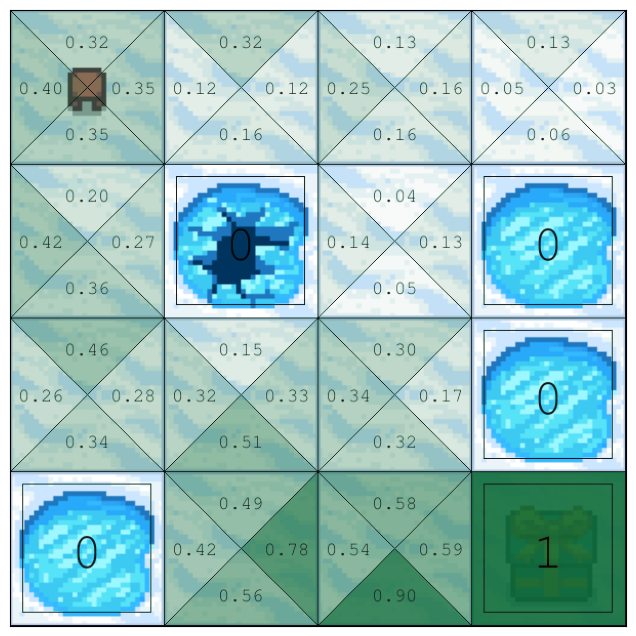

In [11]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array')

plt.figure(figsize=(8, 8))
plt.tick_params(left=False, right=False, labelleft=False,
                labelbottom=False, bottom=False)

env.reset()
img = plt.imshow(env.render(), extent=[-8, 8, -8, 8])
img2 = plt.imshow(np.asarray(gw.render()), extent=[-8, 8, -8, 8], alpha=0.9)
for episode in range(N_EPISODES):
    state, _ = env.reset()
    done = False

    for step in range(MAX_STEPS_PER_EPISODE):
        i, j = state_translate(state)
        # epsilon-greedy action selection
        if np.random.rand() > EPSILON:
            action = action_translate(argmax(q_table[i, j, :]))
        else:
            action = env.action_space.sample()

        new_state, reward, done, truncated, info = env.step(action)
        i_new, j_new = state_translate(new_state)
        action = action_translate(action)

        # updating q-table
        q_table[i, j, action] = q_table[i, j, action] * (1 - ALPHA) + \
            ALPHA * (reward + GAMMA * np.max(q_table[i_new, j_new, :]))

        state = new_state

        img.set_data(env.render())
        img2.set_data(gw.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)

        if done:
            time.sleep(1)
            break
